### Basics: EdgeComputing with tensorflow, Intel NCS and the Traumschreiber

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## constants are for demo purposes
N_CHANNELS = 1
N_WINDOWWIDTH = 1

T_TIMESTEPS = 10000

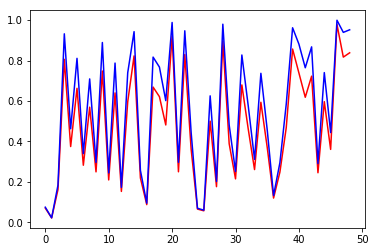

In [2]:
def random_data():
    input_ = np.random.rand(N_CHANNELS, N_WINDOWWIDTH, T_TIMESTEPS)
    output = - input_**3 + input_**2 + input_
    
    return input_.astype(np.float32), output.astype(np.float32)

inp, tar = random_data()
input_ = np.reshape(inp, [T_TIMESTEPS])
target = np.reshape(tar, [T_TIMESTEPS])

p = plt.figure()
ax = p.add_subplot(1,1,1)
ax.plot(input_[1:50], color='red')
ax.plot(target[1:50], color='blue')

In [3]:
class Model(object):
    
    def __init__(self, input_size, output_size, n_neurons, lr, dtype):
        self._input_size = input_size
        self._output_size = output_size
        self._n_neurons = n_neurons
        self._learning_rate = lr
        self._dtype = dtype
        
        self._build_graph()
        
    def _build_graph(self):
        
        # Inputs and targets
        self.input_ = tf.placeholder(dtype=self.dtype, shape=[self.input_size, 1, 1], name="input")
        self.input_ = tf.reshape(self.input_, shape=[1,self.input_size])
        self.target = tf.placeholder(dtype=self.dtype, shape=[1,self.output_size])
        
        # a fully connected neural network layer
        b_inp = tf.get_variable("bias_layer1", [self.n_neurons])
        W_inp = tf.get_variable("weights_layer1", [self.input_size, self.n_neurons], dtype=self.dtype)
        first_layer_linear = tf.add(tf.matmul(self.input_, W_inp), b_inp)
        first_layer = tf.nn.tanh(first_layer_linear)
        
        # perceptron output, final layer
        b_out = tf.get_variable("bias_layer2", [self.output_size])
        W_out = tf.get_variable("weights_layer2", [self.n_neurons, self.output_size])
        second_layer_linear = tf.add(tf.matmul(first_layer, W_out), b_out)
        self.output = tf.nn.tanh(second_layer_linear, name="output")
    
        ### The "real" modelling stops now, but we'll have to add all operations needed to actually train
        ### the network!
        
        # loss, gradient, optimizer
        loss = tf.losses.mean_squared_error(self.target, self.output)
        
        tvars = tf.trainable_variables()
        grads = tf.gradients(loss, tvars)
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars), 
                            global_step=tf.train.get_or_create_global_step())      
    
    @property
    def n_neurons(self):
        return self._n_neurons
    
    @property
    def learning_rate(self):
        return self._learning_rate
    
    @property
    def input_size(self):
        return self._input_size
    
    @property 
    def output_size(self):
        return self._output_size
    
    @property
    def dtype(self):
        return self._dtype        

In [4]:
m = Model(1, 1, 20, 1e-2, tf.float32)

In [5]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    err = 0
    for t in range(T_TIMESTEPS):
        feed_dict = {m.input_: inp[:,:,t], m.target: tar[:,:,t]}
        out, _ = sess.run([m.output, m.train_op], feed_dict)
        err += (out - tar[:,:,t]) **2
        
        if T_TIMESTEPS - t < 10:
            print("TARGET: {} and PREDICTION: {}".format(target[t], out))
            
    saver.save(sess, "tmp/model.ckpt")
    
    RMSE = np.sqrt( 1/T_TIMESTEPS * err )
    print("Average RMSE: {}".format(RMSE))

TARGET: 0.9221025109291077 and PREDICTION: [[ 0.86941844]]
TARGET: 0.13047908246517181 and PREDICTION: [[ 0.10740609]]
TARGET: 0.46067655086517334 and PREDICTION: [[ 0.50521761]]
TARGET: 0.8024540543556213 and PREDICTION: [[ 0.79068768]]
TARGET: 0.46443459391593933 and PREDICTION: [[ 0.50692564]]
TARGET: 0.5400722026824951 and PREDICTION: [[ 0.57834387]]
TARGET: 0.9386680126190186 and PREDICTION: [[ 0.87907094]]
TARGET: 0.10174386948347092 and PREDICTION: [[ 0.0623954]]
TARGET: 0.5552879571914673 and PREDICTION: [[ 0.59403497]]
Average RMSE: [[ 0.07101621]]
